# Malawi Flood Challenge

In [2]:
# import librairies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn import datasets
import pygeohash as pgh
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from math import sin, cos, sqrt, atan2, radians
from geojson import Point, MultiPoint
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#import and explore data
data = pd.read_csv('Train.csv')
sample = pd.read_csv('SampleSubmission.csv')
data.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41


In [4]:
#look for missing data 
cols_with_missing = [col for col in data.columns
                     if data[col].isnull().any()]

In [45]:
#Divide the data into train, validation and test data
train_features = ['X', 'Y', 'elevation', 'precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15','LC_Type1_mode']
test_features = ['X', 'Y','elevation','precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
       'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
       'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
       'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
       'precip 2019-05-12 - 2019-05-19', 'LC_Type1_mode']
X = data[train_features].copy()
X_test = data[test_features].copy()
y = data['target_2015'].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1,
                                                      random_state=0)


# Testing different models

In [46]:
#test random forest and change hyperparameters
Random_Forest_model = RandomForestRegressor(n_estimators=100, random_state=0)
Random_Forest_model.fit(X_train, y_train)
ypred = abs(Random_Forest_model.predict(X_valid))
print(sum(abs(ypred - y_valid)))

50.6281205308808


In [47]:
#test xgboost and change hyperparmeters
XGB_model = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=4)
XGB_model.fit(X_train, y_train)
ypred = abs(XGB_model.predict(X_valid))
print(sum(abs(ypred - y_valid)))


[12:08:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.79791513738863


In [48]:
models = [Random_Forest_model, XGB_model]

for model in models:
    
    score = -1 * cross_val_score(model, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    print("Average MAE score for",model, "is", score.mean())
    

Average MAE score for RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False) is 0.09314607509830566
[12:09:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

In [49]:
#test lgb and change hyperparameters
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)
param = {'num_leaves': 200, 'objective': 'binary'}
param['metric'] = 'l1'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)
ypred = abs(bst.predict(X_valid))
print(sum(abs(ypred - y_valid)))

137.7343432648075


In [50]:
#test catboost and change hyperparameters
cat_model = CatBoostRegressor(iterations=30, learning_rate=0.6, depth=10)
cat_model.fit(X_train, y_train)
preds = cat_model.predict(X_valid)
print(sum(abs(preds - y_valid)))

0:	learn: 0.1667690	total: 303ms	remaining: 8.78s
1:	learn: 0.1424502	total: 597ms	remaining: 8.36s
2:	learn: 0.1341229	total: 906ms	remaining: 8.16s
3:	learn: 0.1299886	total: 1.23s	remaining: 8.01s
4:	learn: 0.1237261	total: 1.55s	remaining: 7.75s
5:	learn: 0.1232402	total: 1.58s	remaining: 6.31s
6:	learn: 0.1227176	total: 1.86s	remaining: 6.11s
7:	learn: 0.1182501	total: 2.15s	remaining: 5.9s
8:	learn: 0.1164206	total: 2.42s	remaining: 5.66s
9:	learn: 0.1157875	total: 2.71s	remaining: 5.41s
10:	learn: 0.1148356	total: 2.99s	remaining: 5.16s
11:	learn: 0.1128288	total: 3.27s	remaining: 4.9s
12:	learn: 0.1125903	total: 3.55s	remaining: 4.64s
13:	learn: 0.1112057	total: 3.82s	remaining: 4.37s
14:	learn: 0.1111543	total: 4s	remaining: 4s
15:	learn: 0.1111533	total: 4.14s	remaining: 3.63s
16:	learn: 0.1111529	total: 4.34s	remaining: 3.32s
17:	learn: 0.1095274	total: 5.33s	remaining: 3.55s
18:	learn: 0.1093676	total: 6.38s	remaining: 3.7s
19:	learn: 0.1081962	total: 7.48s	remaining: 3.74s

# Feature engineering


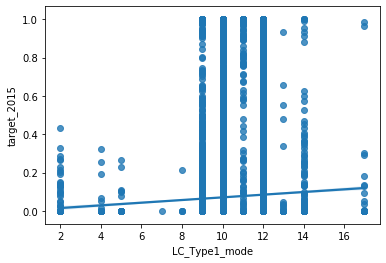

In [51]:
#check the different correlations between features
sns.regplot(x= X_train.LC_Type1_mode, y = y_train)

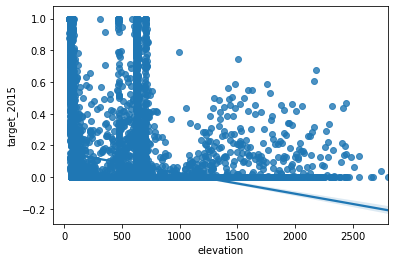

In [52]:
sns.regplot(x= X_train.elevation, y = y_train)

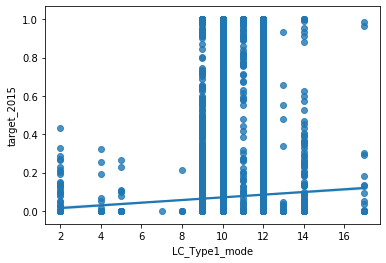

In [53]:
sns.regplot(x= X_train.LC_Type1_mode , y = y_train)

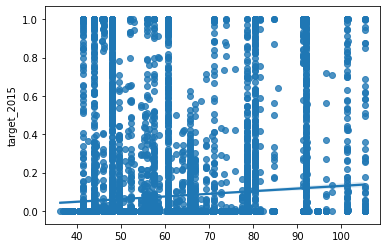

In [54]:
feat = ['precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15']
test_feat = ['precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
       'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
       'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
       'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
       'precip 2019-05-12 - 2019-05-19']
#calculating the maximum of precipitation for the train data
precip_max =X_train[feat].max(axis =1)
sns.regplot(x= precip_max , y = y_train)

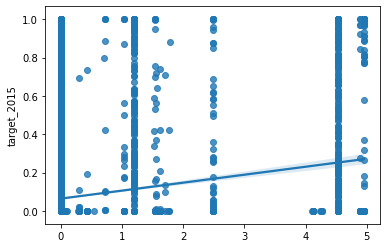

In [55]:
precip_min =X_train[feat].min(axis =1)
sns.regplot(x=precip_min  , y = y_train)

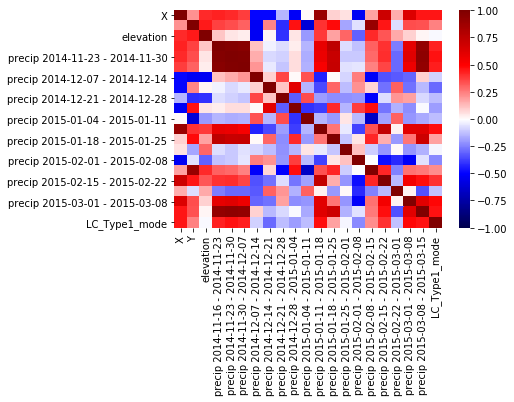

In [56]:
sns.heatmap(X_train.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

[26522.7689967365, 41198.88160486021, 19134.741766817104, 136183.85696054372, 146423.23278920318, 157626.06441133458, 377483.6478926689, 462912.1164237642, 969175.7180148631, 20601.818552636203, 570599.2198789973, 466232.9503488563, 205625.9095286183, 62613.3432921204, 281112.25228885177, 150020.87908741258, 5444.3347560449]


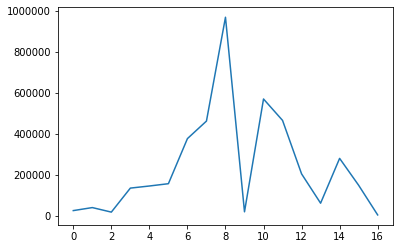

In [57]:
#check the precipitations total according to their week
tab = []
for i in range(len(feat)):
    tab.append(np.sum(X[feat[i]]))
print(tab)
plt.plot(tab)

[219475.69763500363, 73067.70599106721, 381179.6738812691, 160539.9620923185, 486998.2682775755, 30699.1938149612, 994957.4586064437, 202887.7875499328, 586804.6740108465, 35010.5638486014, 56863.6081942168, 58608.5284523836, 150296.3230601703, 27345.2353206171, 8663.4820412421, 15940.751205129502, 26110.849721709303]
precip 2019-02-03 - 2019-02-10


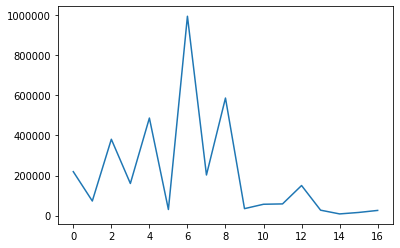

In [58]:
tab = []
for i in range(len(test_feat)):
    tab.append(np.sum(data[test_feat[i]]))
print(tab)
plt.plot(tab)
print(test_feat[len(test_feat)-15])

In [118]:
#adding some features: mean, min, max, std, 25%, 50%, 75% and std 
data['mean'] =data[feat].mean(axis =1)
data['max'] = data[feat].max(axis =1)
data['min'] = data[feat].min(axis =1)
data['std'] = data[feat].std(axis = 1)
data['25percentile'] = np.percentile(data[feat],25, axis =1)
data['50percentile'] = np.percentile(data[feat],50, axis =1)
data['75percentile'] = np.percentile(data[feat],75, axis =1)
data['test_mean'] = data[test_feat].mean(axis =1)
data['test_max'] = data[test_feat].mean(axis = 1)
data['test_min'] = data[test_feat].min(axis = 1)
data['test_std'] = data[test_feat].std(axis = 1)
data['test_25percentile'] = np.percentile(data[test_feat],25, axis =1)
data['test_50percentile'] = np.percentile(data[test_feat],50, axis =1)
data['test_75percentile'] = np.percentile(data[test_feat],75, axis =1)
#Add new precipitation columns that add up precipitations over each 2 weeks
for i in range(0,16,2):
    data["precip" + str(i)] = data[[feat[i],feat[i+1]]].sum(axis =1)
for i in range(0,16,2):
    data["test_precip" + str(i)] = data[[test_feat[i],test_feat[i+1]]].sum(axis =1)
data1 = data.copy()
#keep the precipitations calculated over 2 weeks and delete the precipitations for each week data
train_features = ['X', 'Y','elevation', 'precip0','precip2',
                  'precip4', 'precip6', 'precip8','precip10', 'precip12', 'precip14',
                 'LC_Type1_mode', 'mean', 'max']
test_features = ['X', 'Y','elevation','test_precip0','test_precip2', 'test_precip4', 'test_precip6',
                  'test_precip8','test_precip10', 'test_precip12', 'test_precip14',
                 'LC_Type1_mode','test_mean', 'test_max']
X_test = data1[test_features].copy()
X = data1[train_features].copy()
y = data1['target_2015'].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1,
                                                      random_state=0)


In [119]:
# use lightgb to predict
X_trainbis= X_train.copy()
X_validbis= X_valid.copy()
X_testbis = X_test.copy()
dtrain = lgb.Dataset(X_trainbis, label=y_train)
dvalid = lgb.Dataset(X_validbis, label=y_valid)
param = {'num_leaves': 200, 'objective': 'binary'}
param['metric'] = 'l1'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

In [120]:
ypred = abs(bst.predict(X_validbis))
print(sum(abs(ypred - y_valid)))

137.98673469056143


In [121]:
ypred = abs(bst.predict(X_test))
lgb_result = pd.DataFrame({'Square_ID': data.Square_ID, 'target_2019':ypred })
lgb_result.to_csv('output.csv', index=False) 
lgb_result.head()

,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.000022
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.000026
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.000047
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.000052
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.000130
